In [58]:
import time
from typing import Optional, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split

In [59]:
class NoiseScheduler:
    """Handles noise scheduling for diffusion process"""

    def __init__(self, num_timesteps: int = 1000,
                 beta_start: float = 1e-4,
                 beta_end: float = 0.02,
                 schedule_type: str = 'linear',
                 device: Optional[torch.device] = None):
        self.num_timesteps = num_timesteps
        self.device = device

        if schedule_type == 'linear':
            self.betas = self._linear_schedule(beta_start, beta_end, num_timesteps)
        elif schedule_type == 'cosine':
            self.betas = self._cosine_schedule(num_timesteps)
        else:
            raise ValueError(f"Unsupported schedule type: {schedule_type}. Choose 'linear' or 'cosine'.")

        # Move betas to device early
        if self.device is not None:
            self.betas = self.betas.to(self.device)

        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.posterior_variance = self.betas * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)

    def _linear_schedule(self, beta_start: float, beta_end: float, num_timesteps: int) -> torch.Tensor:
        return torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32)

    def _cosine_schedule(self, num_timesteps: int) -> torch.Tensor:
        s = 0.008
        steps = num_timesteps + 1
        x = torch.linspace(0, num_timesteps, steps, dtype=torch.float32)
        alphas_cumprod = torch.cos(((x / num_timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

    def q_sample(self,
                 x_start: torch.Tensor,
                 t: torch.Tensor,
                 mask: torch.Tensor,
                 noise: Optional[torch.Tensor] = None):
        """Forward diffusion process - add noise only to target regions"""
        if noise is None:
            noise = torch.randn_like(x_start)

        # Reshape for broadcasting (B, 1, 1)
        sqrt_alphas_cumprod_t = self.alphas_cumprod[t].sqrt().view(-1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = (1 - self.alphas_cumprod[t]).sqrt().view(-1, 1, 1)

        # Apply noise only where mask is 0 (target regions)
        noisy_sample = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

        # Keep original values where mask is 1 (conditioning regions)
        return x_start * mask + noisy_sample * (~mask)


In [60]:
class SinusoidalPositionalEmbedding(nn.Module):
    """
    Creates sinusoidal positional embeddings for timestep encoding.
    """

    def __init__(self, embedding_dim: int):
        """
        Initialize the sinusoidal positional embedding.

        Args:
            embedding_dim: Dimension of the output embedding
        """
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, timesteps: torch.Tensor) -> torch.Tensor:
        """
        Convert timesteps to sinusoidal embeddings.

        Args:
            timesteps: Tensor of shape (batch_size,) containing timestep values

        Returns:
            embeddings: Tensor of shape (batch_size, embedding_dim) containing
                       sinusoidal positional embeddings
        """
        device = timesteps.device
        half_dim = self.embedding_dim // 2

        # Create frequency scaling factors using exponential decay
        frequencies = torch.exp(
            -torch.log(torch.tensor(10000.0)) *
            torch.arange(half_dim, device=device) / half_dim
        )

        # Apply frequencies to timesteps to get phase arguments
        args = timesteps[:, None] * frequencies[None, :]

        # Create embeddings using both cosine and sine
        embeddings = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

        return embeddings


class AdaGN(nn.Module):
    """
    Adaptive Group Normalization conditioned on time embedding.

    This module applies Group Normalization and then modulates the normalized
    features using scale and shift parameters derived from the time embedding.
    This allows the model to adapt its normalization based on the diffusion timestep.
    """

    def __init__(self, num_groups: int, num_channels: int, emb_dim: int):
        """
        Initialize Adaptive Group Normalization.

        Args:
            num_groups: Number of groups for GroupNorm (typically 8 or 32)
            num_channels: Number of input channels to normalize
            emb_dim: Dimension of the time embedding
        """
        super().__init__()
        self.num_groups = num_groups
        self.num_channels = num_channels

        # Standard Group Normalization
        self.group_norm = nn.GroupNorm(num_groups, num_channels)

        # MLP to generate scale and shift parameters from time embedding
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, 2 * num_channels)
        )

    def forward(self, x: torch.Tensor, emb: torch.Tensor) -> torch.Tensor:
        """
        Apply adaptive group normalization.

        Args:
            x: Input tensor of shape (batch, channels, length)
            emb: Time embedding of shape (batch, emb_dim)

        Returns:
            Normalized and modulated tensor of shape (batch, channels, length)
        """
        # Apply standard group normalization first
        x = self.group_norm(x)

        # Generate scale and shift parameters from time embedding
        emb_out = self.emb_layers(emb)  # (batch, 2 * channels)
        scale, shift = emb_out.chunk(2, dim=1)  # Each: (batch, channels)

        # Reshape for broadcasting over length dimension
        scale = scale.unsqueeze(-1)  # (batch, channels, 1)
        shift = shift.unsqueeze(-1)  # (batch, channels, 1)

        # Apply adaptive modulation: scale around 1, then shift
        return x * (1 + scale) + shift


class ResidualBlock1D(nn.Module):
    """
    A 1D Residual Block with time embedding conditioning.

    This block follows the typical ResNet structure with two convolutions,
    but adds time embedding conditioning via AdaGN and includes dropout
    for regularization.
    """

    def __init__(self, in_channels: int, out_channels: int, time_emb_dim: int,
                 kernel_size: int = 3, num_groups: int = 8, dropout: float = 0.0):
        """
        Initialize the residual block.

        Args:
            in_channels: Number of input channels
            out_channels: Number of output channels
            time_emb_dim: Dimension of time embedding
            kernel_size: Convolution kernel size (default: 3)
            num_groups: Number of groups for GroupNorm (default: 8)
            dropout: Dropout probability (default: 0.0)
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout = dropout

        # Time embedding projection - adds time information to features
        self.time_emb_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )

        # First convolution path
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=kernel_size // 2)
        self.norm1 = AdaGN(num_groups, out_channels, time_emb_dim)

        # Dropout layer for regularization
        self.dropout1 = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        # Second convolution path
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=kernel_size // 2)
        self.norm2 = AdaGN(num_groups, out_channels, time_emb_dim)

        # Second dropout layer
        self.dropout2 = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        # Skip connection - handles channel dimension mismatch
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x: torch.Tensor, time_emb: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the residual block.

        Args:
            x: Input tensor of shape (batch, in_channels, length)
            time_emb: Time embedding of shape (batch, time_emb_dim)

        Returns:
            Output tensor of shape (batch, out_channels, length)
        """
        h = x

        # First convolution block
        h = self.conv1(h)
        h = self.norm1(h, time_emb)
        h = F.silu(h)
        h = self.dropout1(h)

        # Add time embedding information
        time_proj = self.time_emb_proj(time_emb).unsqueeze(-1)  # (batch, out_channels, 1)
        h = h + time_proj

        # Second convolution block
        h = self.conv2(h)
        h = self.norm2(h, time_emb)
        h = F.silu(h)
        h = self.dropout2(h)

        # Residual connection
        return h + self.shortcut(x)


class AttentionBlock1D(nn.Module):
    """
    Self-attention block for 1D sequences.

    This implements multi-head self-attention to allow the model to attend
    to different parts of the sequence.
    """

    def __init__(self, channels: int, num_heads: int = 8):
        """
        Initialize the attention block.

        Args:
            channels: Number of input/output channels
            num_heads: Number of attention heads
        """
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.head_dim = channels // num_heads

        assert channels % num_heads == 0, f"channels ({channels}) must be divisible by num_heads ({num_heads})"

        # Layer normalization before attention
        self.norm = nn.GroupNorm(8, channels)

        # Combined query, key, value projection
        self.qkv = nn.Conv1d(channels, channels * 3, 1)

        # Output projection
        self.proj_out = nn.Conv1d(channels, channels, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Apply self-attention to the input.

        Args:
            x: Input tensor of shape (batch, channels, length)

        Returns:
            Output tensor of shape (batch, channels, length) with residual connection
        """
        batch, channels, length = x.shape

        # Normalize input
        h = self.norm(x)

        # Generate queries, keys, and values
        qkv = self.qkv(h)  # (batch, 3*channels, length)

        # Reshape for multi-head attention
        qkv = qkv.view(batch, 3, self.num_heads, self.head_dim, length)
        q, k, v = qkv.unbind(1)  # Each: (batch, num_heads, head_dim, length)

        # Transpose for attention computation
        q = q.transpose(-2, -1)  # (batch, num_heads, length, head_dim)
        k = k.transpose(-2, -1)  # (batch, num_heads, length, head_dim)
        v = v.transpose(-2, -1)  # (batch, num_heads, length, head_dim)

        # Scaled dot-product attention
        scale = (self.head_dim ** -0.5)
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale
        attn = F.softmax(attn, dim=-1)

        # Apply attention to values
        out = torch.matmul(attn, v)  # (batch, num_heads, length, head_dim)

        # Reshape back to original format
        out = out.transpose(-2, -1).contiguous()  # (batch, num_heads, head_dim, length)
        out = out.view(batch, channels, length)

        # Output projection and residual connection
        out = self.proj_out(out)
        return x + out


class Downsample1D(nn.Module):
    """
    Downsampling block for reducing sequence length by factor of 2.

    Can use either strided convolution (learnable) or average pooling.
    """

    def __init__(self, channels: int, use_conv: bool = True):
        """
        Initialize downsampling block.

        Args:
            channels: Number of channels
            use_conv: If True, use learnable conv; if False, use avg pooling
        """
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            # Learnable downsampling with strided convolution
            self.conv = nn.Conv1d(channels, channels, 3, stride=2, padding=1)
        else:
            # Simple average pooling
            self.conv = nn.AvgPool1d(2, stride=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Downsample input by factor of 2."""
        return self.conv(x)


class Upsample1D(nn.Module):
    """
    Upsampling block for increasing sequence length by factor of 2.

    Can use either transposed convolution (learnable) or nearest neighbor interpolation.
    """

    def __init__(self, channels: int, use_conv: bool = True):
        """
        Initialize upsampling block.

        Args:
            channels: Number of channels
            use_conv: If True, use learnable conv; if False, use interpolation
        """
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            # Learnable upsampling with transposed convolution
            self.conv = nn.ConvTranspose1d(channels, channels, 4, stride=2, padding=1)
        else:
            # Simple nearest neighbor upsampling
            self.conv = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Upsample input by factor of 2."""
        return self.conv(x)


class UNet1D(nn.Module):
    """
    1D U-Net architecture for time series denoising in diffusion models.

    The architecture includes:
    - Time embedding for diffusion timestep conditioning
    - Optional conditioning on external signals
    - Multi-scale processing with skip connections
    - Self-attention at specified resolutions
    - Dropout for regularization
    """

    def __init__(self,
                 in_channels: int = 1,
                 out_channels: int = 1,
                 model_channels: int = 64,
                 num_res_blocks: int = 2,
                 attention_resolutions: tuple = (2, 4),
                 channel_mult: tuple = (1, 2, 4),
                 num_heads: int = 8,
                 dropout: float = 0.1,
                 time_embed_dim: int = None):
        """
        Initialize the 1D U-Net model.

        Args:
            in_channels: Number of input channels
            out_channels: Number of output channels
            model_channels: Base number of channels
            num_res_blocks: Number of residual blocks per resolution
            attention_resolutions: Resolutions where to apply attention
            channel_mult: Channel multipliers for each resolution
            num_heads: Number of attention heads
            dropout: Dropout probability
            time_embed_dim: Time embedding dimension
        """
        super().__init__()

        # Set default time embedding dimension
        if time_embed_dim is None:
            time_embed_dim = model_channels * 4

        # Store configuration
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.model_channels = model_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.channel_mult = channel_mult
        self.num_heads = num_heads
        self.dropout = dropout

        # Time embedding network
        # Converts scalar timesteps to high-dimensional embeddings
        self.time_embed = nn.Sequential(
            SinusoidalPositionalEmbedding(model_channels),
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # Condition embedding (for external conditioning signals)
        self.cond_embed = nn.Conv1d(in_channels, model_channels, 1)

        # Input projection - maps input channels to model channels
        self.input_proj = nn.Conv1d(in_channels, model_channels, 3, padding=1)

        # Build encoder (downsampling) path
        self.down_blocks = nn.ModuleList()
        self.down_samples = nn.ModuleList()

        # Track channels at each resolution for skip connections
        self.skip_channels = []

        ch = model_channels
        ds = 1  # Current downsampling factor

        # Create encoder blocks at each resolution
        for level, mult in enumerate(channel_mult):
            out_ch = model_channels * mult

            # Create residual blocks for this resolution level
            blocks = nn.ModuleList()
            for i in range(num_res_blocks):
                blocks.append(ResidualBlock1D(ch, out_ch, time_embed_dim, dropout=dropout))
                ch = out_ch

                # Add self-attention at specified resolutions
                if ds in attention_resolutions:
                    blocks.append(AttentionBlock1D(ch, num_heads))

            self.down_blocks.append(blocks)
            self.skip_channels.append(ch)

            # Add downsampling (except for the deepest level)
            if level < len(channel_mult) - 1:
                self.down_samples.append(Downsample1D(ch))
                ds *= 2
            else:
                self.down_samples.append(None)

        # Middle block (bottleneck)
        # Additional processing at the deepest resolution
        self.mid_block1 = ResidualBlock1D(ch, ch, time_embed_dim, dropout=dropout)
        self.mid_attn = AttentionBlock1D(ch, num_heads)
        self.mid_block2 = ResidualBlock1D(ch, ch, time_embed_dim, dropout=dropout)

        # Build decoder (upsampling) path
        self.up_blocks = nn.ModuleList()
        self.up_samples = nn.ModuleList()

        # Create decoder blocks (reverse order of encoder)
        for level, mult in reversed(list(enumerate(channel_mult))):
            out_ch = model_channels * mult

            # Create residual blocks for this resolution level
            blocks = nn.ModuleList()
            for i in range(num_res_blocks + 1):  # +1 for extra block after skip connection
                # First block needs to handle concatenated skip connection
                if i == 0:
                    in_ch = ch + self.skip_channels[level]  # current + skip channels
                else:
                    in_ch = out_ch

                blocks.append(ResidualBlock1D(in_ch, out_ch, time_embed_dim, dropout=dropout))
                ch = out_ch

                # Add self-attention at specified resolutions
                if ds in attention_resolutions:
                    blocks.append(AttentionBlock1D(ch, num_heads))

            self.up_blocks.append(blocks)

            # Add upsampling (except for the final output level)
            if level > 0:
                self.up_samples.append(Upsample1D(ch))
                ds //= 2
            else:
                self.up_samples.append(None)

        # Output projection - maps back to desired output channels
        self.out_norm = nn.GroupNorm(8, ch)
        self.out_conv = nn.Conv1d(ch, out_channels, 3, padding=1)

    def forward(self, x: torch.Tensor, timesteps: torch.Tensor,
                condition: torch.Tensor = None) -> torch.Tensor:
        """
        Forward pass through the U-Net.

        Args:
            x: Noisy input tensor of shape (batch, in_channels, length)
            timesteps: Diffusion timesteps of shape (batch,)
            condition: Optional conditioning signal of shape (batch, in_channels, length)

        Returns:
            Denoised output tensor of shape (batch, out_channels, length)
        """

        # Ensure input has correct number of channels
        if x.shape[1] != self.in_channels:
            raise ValueError(f"Input has {x.shape[1]} channels, expected {self.in_channels}")

        # Generate time embedding for all timesteps
        time_emb = self.time_embed(timesteps)

        # Combine input with optional conditioning
        if condition is not None:
            # Project conditioning signal and add to input projection
            cond_emb = self.cond_embed(condition)
            h = self.input_proj(x) + cond_emb
        else:
            h = self.input_proj(x)

        # Encoder path - progressively downsample while storing skip connections
        skips = []

        for level, (blocks, downsample) in enumerate(zip(self.down_blocks, self.down_samples)):
            # Apply all blocks at this resolution level
            for block in blocks:
                if isinstance(block, ResidualBlock1D):
                    h = block(h, time_emb)
                else:  # AttentionBlock1D
                    h = block(h)

            # Store for skip connection
            skips.append(h)

            # Downsample if not at deepest level
            if downsample is not None:
                h = downsample(h)

        # Middle processing at bottleneck
        h = self.mid_block1(h, time_emb)
        h = self.mid_attn(h)
        h = self.mid_block2(h, time_emb)

        # Decoder path - progressively upsample while using skip connections
        for level, (blocks, upsample) in enumerate(zip(self.up_blocks, self.up_samples)):
            # Concatenate skip connection for first block
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)

            # Apply all blocks at this resolution level
            for block in blocks:
                if isinstance(block, ResidualBlock1D):
                    h = block(h, time_emb)
                else:  # AttentionBlock1D
                    h = block(h)

            # Upsample if not at final level
            if upsample is not None:
                h = upsample(h)

        # Final output processing
        h = self.out_norm(h)
        h = F.silu(h)
        h = self.out_conv(h)

        return h

In [61]:
class NoiseScheduler:
    """Handles noise scheduling for diffusion process"""

    def __init__(self, num_timesteps: int = 1000,
                 beta_start: float = 1e-4,
                 beta_end: float = 0.02,
                 schedule_type: str = 'linear',
                 device: Optional[torch.device] = None):
        self.num_timesteps = num_timesteps
        self.device = device

        if schedule_type == 'linear':
            self.betas = self._linear_schedule(beta_start, beta_end, num_timesteps)
        elif schedule_type == 'cosine':
            self.betas = self._cosine_schedule(num_timesteps)
        else:
            raise ValueError(f"Unsupported schedule type: {schedule_type}. Choose 'linear' or 'cosine'.")

        # Move betas to device early
        if self.device is not None:
            self.betas = self.betas.to(self.device)

        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.posterior_variance = self.betas * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)

    def _linear_schedule(self, beta_start: float, beta_end: float, num_timesteps: int) -> torch.Tensor:
        return torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32)

    def _cosine_schedule(self, num_timesteps: int) -> torch.Tensor:
        s = 0.008
        steps = num_timesteps + 1
        x = torch.linspace(0, num_timesteps, steps, dtype=torch.float32)
        alphas_cumprod = torch.cos(((x / num_timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

    def q_sample(self,
                 x_start: torch.Tensor,
                 t: torch.Tensor,
                 mask: torch.Tensor,
                 noise: Optional[torch.Tensor] = None):
        """Forward diffusion process - add noise only to target regions"""
        if noise is None:
            noise = torch.randn_like(x_start)

        # Reshape for broadcasting (B, 1, 1)
        sqrt_alphas_cumprod_t = self.alphas_cumprod[t].sqrt().view(-1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = (1 - self.alphas_cumprod[t]).sqrt().view(-1, 1, 1)

        # Apply noise only where mask is 0 (target regions)
        noisy_sample = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

        # Keep original values where mask is 1 (conditioning regions)
        return x_start * mask + noisy_sample * (~mask)


In [62]:
class TimeSeriesDDPM:
    """Main diffusion model class"""

    def __init__(self, denoiser: nn.Module, noise_scheduler: NoiseScheduler, device: str = 'cpu'):

        self.denoiser = denoiser.to(device)
        self.noise_scheduler = noise_scheduler
        self.device = device

    def training_step(self, batch: Dict[str, torch.Tensor]) -> torch.Tensor:
        """Single training step"""

        full_series = batch['full_series'].to(self.device)
        condition = batch['condition'].to(self.device)
        mask = batch['mask'].to(self.device)

        batch_size = full_series.shape[0]

        # Sample random timesteps
        t = torch.randint(0, self.noise_scheduler.num_timesteps, (batch_size,), device=self.device)

        # Add noise
        noise = torch.randn_like(full_series)
        noisy_series = self.noise_scheduler.q_sample(full_series, t, mask, noise)

        # Predict noise
        predicted_noise = self.denoiser(noisy_series, t, condition)

        # Compute loss only on target regions (where mask == 0)
        loss_mask = ~mask
        loss = F.mse_loss(predicted_noise, noise, reduction='none')
        loss = (loss * loss_mask).sum() / loss_mask.sum()

        return loss

    @torch.no_grad()
    def p_sample(self, x: torch.Tensor, t: torch.Tensor, condition: torch.Tensor, mask: torch.Tensor):
        """Single reverse diffusion step"""

        # Predict noise
        predicted_noise = self.denoiser(x, t, condition)

        # Get coefficients and reshape for broadcasting (B, 1, 1)
        alpha_t = self.noise_scheduler.alphas[t].view(-1, 1, 1)
        alpha_cumprod_t = self.noise_scheduler.alphas_cumprod[t].view(-1, 1, 1)
        beta_t = self.noise_scheduler.betas[t].view(-1, 1, 1)

        # Compute mean
        coeff1 = 1 / alpha_t.sqrt()
        coeff2 = beta_t / (1 - alpha_cumprod_t).sqrt()
        mean = coeff1 * (x - coeff2 * predicted_noise)

        # Add noise (except for t=0)
        if t[0] > 0:
            posterior_variance = self.noise_scheduler.posterior_variance[t].view(-1, 1, 1)
            noise = torch.randn_like(x)
            x_prev = mean + posterior_variance.sqrt() * noise
        else:
            x_prev = mean

        # Re-impose conditioning
        x_prev = condition * mask + x_prev * (~mask)

        return x_prev

    @torch.no_grad()
    def sample(self, condition: torch.Tensor, mask: torch.Tensor, num_inference_steps: Optional[int] = None):
        """Generate samples using reverse diffusion"""
        if num_inference_steps is None:
            num_inference_steps = self.noise_scheduler.num_timesteps

        batch_size, channels, seq_len = condition.shape

        # Start with pure noise in target regions
        x = torch.randn(batch_size, channels, seq_len, device=self.device)
        x = condition * mask + x * (~mask)

        # Reverse diffusion
        timesteps = torch.linspace(self.noise_scheduler.num_timesteps - 1, 0, num_inference_steps, dtype=torch.long)

        for t in timesteps:
            t_batch = torch.full((batch_size,), t, device=self.device, dtype=torch.long)
            x = self.p_sample(x, t_batch, condition, mask)

        return x

In [63]:
class SyntheticTimeSeriesDataset(Dataset):
    """Generate synthetic 1D time series for diffusion model training"""

    def __init__(self,
                 num_samples: int = 1000,
                 seq_length: int = 64,
                 condition_length: int = 32,
                 task_type: str = 'forecasting'):
        """
        Args:
            num_samples: Number of time series to generate
            seq_length: Total length of each time series
            condition_length: Length of conditioning segment
            task_type: 'forecasting' or 'imputation'
        """
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.condition_length = condition_length
        # Validate task_type
        if task_type not in ['forecasting', 'imputation']:
            raise ValueError("task_type must be 'forecasting' or 'imputation'")
        self.task_type = task_type

        # target_length is primarily used for forecasting here
        self.target_length = seq_length - condition_length

        # Generate all data upfront for consistency
        self.data = self._generate_data()

    def _generate_data(self):
        """Generate diverse synthetic time series patterns"""
        data = []

        for i in range(self.num_samples):
            # Cycle through different patterns
            pattern_type = i % 4

            if pattern_type == 0:  # Sine wave with noise
                freq = np.random.uniform(0.1, 0.5)
                phase = np.random.uniform(0, 2 * np.pi)
                amplitude = np.random.uniform(0.5, 2.0)
                t = np.linspace(0, 4 * np.pi, self.seq_length)
                series = amplitude * np.sin(freq * t + phase) + np.random.normal(0, 0.1, self.seq_length)

            elif pattern_type == 1:  # Exponential Decay/Growth with Noise
                initial_value = np.random.uniform(0.5, 2.0)
                # Small negative k for decay
                k = np.random.uniform(-0.1, 0)
                t = np.arange(self.seq_length)
                series = initial_value * np.exp(k * t) + np.random.normal(0, 0.08, self.seq_length)

            elif pattern_type == 2:  # Trend with seasonality
                trend = np.linspace(np.random.uniform(-1, 1), np.random.uniform(-1, 1), self.seq_length)
                # Ensure seasonality period is not too large for short sequences
                seasonal_period = np.random.randint(4, min(self.seq_length // 2, 16) + 1)
                seasonal = 0.3 * np.sin(2 * np.pi * np.arange(self.seq_length) / seasonal_period)
                noise = np.random.normal(0, 0.1, self.seq_length)
                series = trend + seasonal + noise

            elif pattern_type == 3:  # Ornstein-Uhlenbeck (OU) Process
                theta = np.random.uniform(0.05, 0.2) # Rate of reversion
                mu = np.random.uniform(-0.5, 0.5)   # Long-term mean
                sigma = np.random.uniform(0.05, 0.3) # Volatility
                dt = 0.1 # Time step

                series = np.zeros(self.seq_length)
                series[0] = np.random.uniform(-1, 1) # Initial value

                for t in range(1, self.seq_length):
                    series[t] = series[t-1] + theta * (mu - series[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)


            # Normalize to [-1, 1]
            series = (series - series.mean()) / (series.std() + 1e-8)
            series = np.clip(series, -3, 3) / 3  # Clip to -3,3 std deviations and then scale to -1,1

            data.append(series.astype(np.float32))

        return np.array(data)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        series = self.data[idx]

        if self.task_type == 'forecasting':
            if self.target_length < 0:
                raise ValueError("seq_length must be greater than or equal to condition_length for forecasting.")

            target = series[self.condition_length:]
            mask = np.concatenate(
                [np.ones(self.condition_length, dtype=bool), np.zeros(self.target_length, dtype=bool)])

            # Make condition tensor full length, zeroing out the target region
            condition = series.copy()
            condition[self.condition_length:] = 0.0  # Use float for consistency

        if self.task_type == 'imputation':
            condition = series.copy()
            mask = np.ones(self.seq_length, dtype=bool)
            target_values_for_masked_segments = []

            # Determine number of gaps: 2 to 4, but not more than seq_length // 5 to ensure space
            num_gaps = np.random.randint(2, min(5, max(2, self.seq_length // 5)))
            # For very short sequences, ensure at least one gap is possible
            if self.seq_length < 10:
                num_gaps = 1

            # Determine max individual gap length
            max_single_gap_len = max(1, self.seq_length // (num_gaps * 2))  # Ensure at least 1, and leaves space

            masked_ranges = []  # To keep track of already masked (start, end) tuples [inclusive start, exclusive end)

            for _ in range(num_gaps):
                attempts = 0
                gap_found = False
                while attempts < 50 and not gap_found:  # Limit attempts to avoid infinite loops or slow generation
                    current_gap_length = np.random.randint(1, max_single_gap_len + 1)
                    if self.seq_length - current_gap_length < 0:  # Gap is too long for the sequence
                        break

                    start_candidate = np.random.randint(0, self.seq_length - current_gap_length + 1)
                    end_candidate = start_candidate + current_gap_length

                    # Check for overlap with existing masked ranges
                    overlap = False
                    for (m_start, m_end) in masked_ranges:
                        # Overlap occurs if the intervals [start_candidate, end_candidate) and [m_start, m_end) intersect.
                        # This happens if: (start_candidate < m_end) AND (end_candidate > m_start)
                        if (start_candidate < m_end and end_candidate > m_start):
                            overlap = True
                            break

                    if not overlap:
                        # Found a valid non-overlapping spot
                        masked_ranges.append((start_candidate, end_candidate))

                        # Apply mask and condition updates
                        segment_indices = np.arange(start_candidate, end_candidate)
                        condition[segment_indices] = 0.0  # Mask by setting to zero
                        mask[segment_indices] = False
                        target_values_for_masked_segments.append(series[segment_indices])
                        gap_found = True
                    attempts += 1

            # The 'target' tensor contains the true values for ALL masked positions, concatenated.
            if len(target_values_for_masked_segments) > 0:
                target = np.concatenate(target_values_for_masked_segments)
            else:
                # If no gaps were created (e.g., very short sequence or failed attempts),
                # return an empty array for target.
                target = np.array([], dtype=np.float32)

        return {
            'full_series': torch.tensor(series, dtype=torch.float32).unsqueeze(0),
            'condition': torch.tensor(condition, dtype=torch.float32).unsqueeze(0),
            'target': torch.tensor(target, dtype=torch.float32).unsqueeze(0),
            'mask': torch.tensor(mask, dtype=torch.bool).unsqueeze(0)
        }

In [64]:
def train_model(model: TimeSeriesDDPM,
                train_dataloader: DataLoader,
                val_dataloader: DataLoader,
                num_epochs: int = 100,
                learning_rate: float = 1e-3):
    """
    Training loop for the diffusion model with validation, learning rate scheduler,
    TensorBoard logging, and saving the best model based on validation loss.
    Early stopping is removed.
    """

    optimizer = torch.optim.Adam(model.denoiser.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=10,
        min_lr=1e-6
    )

    # Best model saving variable
    best_val_loss = float('inf')

    # Store losses
    train_losses = []
    val_losses = []

    num_params = sum(p.numel() for p in model.denoiser.parameters() if p.requires_grad)
    print(f"Denoiser model parameters: {num_params:,}")
    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.denoiser.train() # Set denoiser to training mode
        epoch_train_losses = []
        epoch_start_time = time.time()

        for batch_idx, batch in enumerate(train_dataloader):
            optimizer.zero_grad()

            loss = model.training_step(batch)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.denoiser.parameters(), 1.0)

            optimizer.step()
            epoch_train_losses.append(loss.item())

        avg_train_loss = np.mean(epoch_train_losses)
        train_losses.append(avg_train_loss)

        # --- Validation Phase ---
        model.denoiser.eval() # Set denoiser to evaluation mode
        epoch_val_losses = []
        with torch.no_grad(): # Disable gradient calculations for validation
            for batch_idx, batch in enumerate(val_dataloader):

                val_loss = model.training_step(batch)
                epoch_val_losses.append(val_loss.item())

        avg_val_loss = np.mean(epoch_val_losses)
        val_losses.append(avg_val_loss)

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, Time: {epoch_time:.2f}s, LR: {optimizer.param_groups[0]['lr']:.8f}")

        # Learning Rate Scheduler step (step with validation loss)
        scheduler.step(avg_val_loss)

    return train_losses, val_losses


In [65]:
def evaluate_model(ddpm_model, test_dataset, num_samples: int = 4, num_inference_steps: Optional[int] = None):
    """
    Evaluate and visualize time series diffusion model results

    Args:
        ddpm_model: TimeSeriesDDPM model instance
        test_dataset: Dataset containing test samples
        num_samples: Number of samples to evaluate and visualize
        num_inference_steps: Number of inference steps for sampling (uses model default if None)
    """

    # Set model to evaluation mode
    ddpm_model.denoiser.eval()

    # Collect samples for evaluation
    results = []

    with torch.no_grad():
        for i in range(min(num_samples, len(test_dataset))):
            # Get test sample
            sample = test_dataset[i]

            # Prepare batch (add batch dimension)
            condition = sample['condition'].unsqueeze(0).to(ddpm_model.device)
            mask = sample['mask'].unsqueeze(0).to(ddpm_model.device)
            full_series = sample['full_series'].unsqueeze(0).to(ddpm_model.device)
            target = sample['target'].unsqueeze(0).to(ddpm_model.device)

            # Generate prediction using diffusion model
            predicted = ddpm_model.sample(condition, mask, num_inference_steps)

            # Store results
            results.append({
                'condition': condition.cpu().squeeze(0),
                'target': target.cpu().squeeze(0),
                'predicted': predicted.cpu().squeeze(0),
                'mask': mask.cpu().squeeze(0),
                'full_series': full_series.cpu().squeeze(0)
            })

    # Create visualization
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 4 * num_samples))
    if num_samples == 1:
        axes = [axes]

    for i, result in enumerate(results):
        ax = axes[i]

        # Extract data
        condition = result['condition'].numpy().flatten()
        target = result['target'].numpy().flatten()
        predicted = result['predicted'].numpy().flatten()
        mask = result['mask'].numpy().flatten()

        # Find the split point (where mask changes from True to False)
        split_idx = np.where(~mask)[0][0] if np.any(~mask) else len(condition)

        # Create x-axis
        x_total = np.arange(len(condition))
        x_known = x_total[:split_idx]
        x_target = x_total[split_idx:]

        # Plot known/condition part
        ax.plot(x_known, condition[:split_idx], 'b-', linewidth=2, label='Known/Condition', marker='o', markersize=3)

        # Plot target (ground truth)
        if len(x_target) > 0:
            ax.plot(x_target, target, 'g-', linewidth=2, label='Ground Truth', marker='s', markersize=3)

            # Plot prediction
            ax.plot(x_target, predicted[split_idx:], 'r--', linewidth=2, label='Predicted', marker='^', markersize=3)

        # Add vertical line at split point
        ax.axvline(x=split_idx - 0.5, color='gray', linestyle=':', alpha=0.7, label='Prediction Start')

        # Formatting
        ax.set_title(f'Sample {i + 1}: Time Series Prediction')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Calculate and display metrics for the predicted part
        if len(x_target) > 0:
            mse = np.mean((target - predicted[split_idx:]) ** 2)
            mae = np.mean(np.abs(target - predicted[split_idx:]))
            ax.text(0.02, 0.98, f'MSE: {mse:.4f}\nMAE: {mae:.4f}',
                    transform=ax.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

In [66]:
seq_lenght = 128
condition_lenght = 64
num_samples = 128

# Create datasets
dataset_forecast = SyntheticTimeSeriesDataset(num_samples=num_samples,
                                     seq_length=seq_lenght,
                                     condition_length=condition_lenght,
                                     task_type='forecasting')

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset and training parameters
seq_lenght = 128
condition_lenght = 96
num_samples = 512

batch_size = 8


dataset_forecast = SyntheticTimeSeriesDataset(num_samples=num_samples,
                                     seq_length=seq_lenght,
                                     condition_length=condition_lenght,
                                     task_type='forecasting')


train_ratio = 0.8
val_ratio = 1.0 - train_ratio

# Prepare train and validation dataloader
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure ratios sum to 1 or adjust slightly for remainder
if not (train_ratio + val_ratio + test_ratio == 1.0):
    print("Warning: Ratios do not sum to 1.0. Adjusting test ratio to fill remainder.")
    test_ratio = 1.0 - train_ratio - val_ratio
    print(f"New test_ratio: {test_ratio:.2f}")



# Split into (Train + Validation) and Test sets
total_size = len(dataset_forecast)
train_val_size = int(train_ratio * total_size) + int(val_ratio * total_size) # Combine train and val sizes
test_size = total_size - train_val_size # The rest goes to test

# Handle potential off-by-one from integer truncation for the final split
train_val_size = total_size - test_size


# Perform the split
train_val_dataset, test_dataset = random_split(
    dataset_forecast, [train_val_size, test_size],
    generator=torch.Generator().manual_seed(42) # For reproducibility
)


# Split the (Train + Validation) set into Train and Validation sets
new_train_ratio_in_train_val = train_ratio / (train_ratio + val_ratio)

train_size = int(new_train_ratio_in_train_val * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size # The rest goes to validation


# Perform the second split
train_dataset, val_dataset = random_split(
    train_val_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42) # Use the same seed or a different one
)

print(f"Total samples: {total_size}")
print(f"Train samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")


# --- Create DataLoaders for all three sets ---
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the denoiser architecture
arch_name = 'UNET1d'
denoiser = UNet1D(
    in_channels = 1,
    out_channels = 1,
    model_channels = 64,
    num_res_blocks = 2,
    attention_resolutions = (2, 4),
    channel_mult = (1, 2, 4),
    num_heads = 8,
    dropout = 0.1,
    time_embed_dim = None
    ).to(device)

# Initialize the noise scheduler
noise_scheduler = NoiseScheduler(num_timesteps=1000, schedule_type='linear')

# Create the Denoising Diffusion Probabilistic Model (DDPM)
ddpm_model = TimeSeriesDDPM(denoiser, noise_scheduler, device=device)


num_epochs = 5
learning_rate = 0.001

# Train the DDPM model
training_losses = train_model(
    ddpm_model,
    train_dataloader,
    val_dataloader,
    num_epochs=num_epochs,
    learning_rate=learning_rate)

Total samples: 500
Train samples: 350
Validation samples: 75
Test samples: 75
Denoiser model parameters: 9,737,089
Starting training for 5 epochs...
Epoch 1/5, Train Loss: 0.352337, Val Loss: 0.054665, Time: 40.79s, LR: 0.00100000
Epoch 2/5, Train Loss: 0.120156, Val Loss: 0.155659, Time: 40.30s, LR: 0.00100000
Epoch 3/5, Train Loss: 0.104479, Val Loss: 0.077167, Time: 42.95s, LR: 0.00100000
Epoch 4/5, Train Loss: 0.093224, Val Loss: 0.092154, Time: 46.97s, LR: 0.00100000
Epoch 5/5, Train Loss: 0.090394, Val Loss: 0.070090, Time: 46.39s, LR: 0.00100000


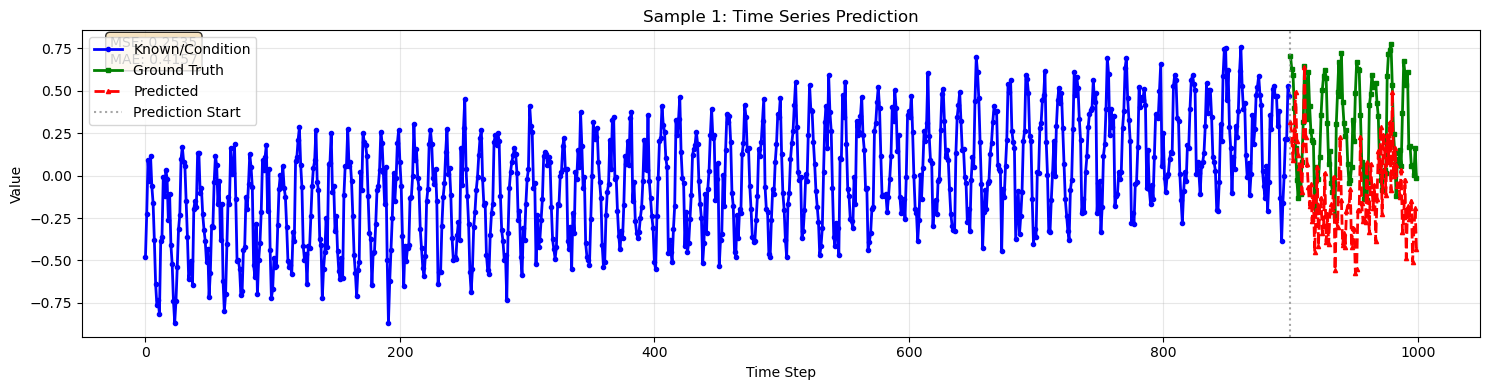

In [72]:
evaluate_model(ddpm_model, test_dataset, num_samples=1, num_inference_steps=1000)